<a href="https://colab.research.google.com/github/madanmohan-venkatesan/notebooks/blob/main/2011_03567.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
from scipy.special import gamma
from scipy.optimize import minimize
from matplotlib import pyplot as plt
import seaborn as sns

# 2. A sequential multinomial test


In [4]:
#CONSTANTS
CLASSES=2
VECTOR_SIZE=100

In [5]:
theta_null=np.array([1/CLASSES]*CLASSES) #Simplex
rng = np.random.default_rng()
vectors_null=rng.multinomial(1,theta_null,size=VECTOR_SIZE)

In [6]:
K=100
alpha_dirichlet=K*theta_null
rng = np.random.default_rng()
theta_alt=rng.dirichlet(alpha_dirichlet)
vectors_alt=rng.multinomial(1,theta_alt,size=VECTOR_SIZE)

In [7]:
s_n_null=np.sum(vectors_null,axis=0)
s_n_alt=np.sum(vectors_alt,axis=0)

In [8]:
def beta(v):

  gamma_v=gamma(v)
  numerator=np.prod(v,where=np.isfinite(gamma_v))
  denominator=gamma(np.sum(v,where=np.isfinite(v)))
  result=numerator/denominator
  if np.isnan(result).any():
    return np.array([np.inf])
  else:
    return result


In [9]:
def bf_10(dirichlet_alpha,theta,counts):
  term1_numerator=beta(dirichlet_alpha+counts)
  term1_denominator=beta(dirichlet_alpha)
  term1=term1_numerator/term1_denominator

  term2=1/(theta**counts)
  result=term1*term2

  if np.isnan(result).any() or np.isinf(result).any():
    return np.array([np.inf]*len(result))
  else:
    return result


In [9]:
bf_10(alpha_dirichlet,theta_null,s_n_alt)

array([0., 0.])

For above bf_10, if theta_0 not equal theta then values will go to infinity (reject null hypothesis)
otherwise value is zero(accept null hypothesis)

Hyper paramters to play around with are K and vector size



In [10]:
theta_null_arr=[]
theta_alt_arr=[]
dirichlet_alpha_arr=[]
vetors_null_arr=[]
vectors_alt_arr=[]
for i in range(10):
  if i==0:
    K=10
  else:
    K=K#+(0.5*K)
  #generate null vectors
  theta_null=np.array([1/CLASSES]*CLASSES) #Simplex
  rng = np.random.default_rng()
  vectors_null=rng.multinomial(1,theta_null,size=VECTOR_SIZE)
  #generate alt vectors

  alpha_dirichlet=K*theta_null
  rng = np.random.default_rng()
  theta_alt=rng.dirichlet(alpha_dirichlet)
  vectors_alt=rng.multinomial(1,theta_alt,size=VECTOR_SIZE)

  theta_null_arr.append(theta_null)
  theta_alt_arr.append(theta_alt)
  dirichlet_alpha_arr.append(alpha_dirichlet)
  vetors_null_arr.append(vectors_null)
  vectors_alt_arr.append(vectors_alt)

In [11]:
on_theta_hist_arr=[]
for i in range(len(theta_null_arr)):
  on_theta_prev = None
  if i==0:
    on_theta_prev = np.array([1,1])
    on_theta_hist_arr.append(on_theta_prev)

  else:
    s_n_null=np.sum(vetors_null_arr[i],axis=0)
    s_n_alt=np.sum(vectors_alt_arr[i],axis=0)
    term1_numerator=beta(dirichlet_alpha_arr[i]+s_n_alt)
    term1_denominator=beta(dirichlet_alpha_arr[i])
    term1=term1_numerator/term1_denominator

    term2=1/(theta_null_arr[i]**s_n_alt)

    on_theta_hist_arr.append(on_theta_hist_arr[i-1]*term1*term2)

# Optimization problem for theta

In [12]:
def objective(theta, i,maximize=True):
    """
    Objective function to maximize theta_i.

    Parameters:
    - theta (array): Probability vector (simplex).
    - i (int): Index of the element to maximize.

    Returns:
    - float: Negative of theta[i] to convert minimization to maximization.
    """
    if maximize:
        return -theta[i]
    else:
      return theta[i]

def constraint_sum(theta):
    """
    Constraint ensuring that the sum of theta is 1.

    Parameters:
    - theta (array): Probability vector (simplex).

    Returns:
    - float: Sum of theta - 1 (should be 0).
    """
    return np.sum(theta) - 1

def constraint_log_likelihood(theta, Sn, c):
    """
    Log-likelihood constraint.

    Parameters:
    - theta (array): Probability vector (simplex).
    - Sn (array): Observed count vector S_{n,i}.
    - c (float): Constant c + log u.

    Returns:
    - float: Left-hand side of the constraint.
    """

    epsilon = 1e-10
    return np.sum(Sn * np.log(np.clip(theta, epsilon, None))) - c

# Real simulation

In [13]:
#CONSTANTS
CLASSES=2
VECTOR_SIZE=100

theta_null=np.array([1/CLASSES]*CLASSES) #Simplex
rng = np.random.default_rng()
vectors_null=rng.multinomial(1,theta_null,size=VECTOR_SIZE)
K=100
alpha_dirichlet=K*theta_null
rng = np.random.default_rng()
theta_alt=rng.dirichlet(alpha_dirichlet)
vectors_alt=rng.multinomial(1,theta_alt,size=VECTOR_SIZE)


on_theta_hist_arr=[]
theta_alt_1max_arr=[]
theta_alt_1min_arr=[]

theta_alt_0max_arr=[]
theta_alt_0min_arr=[]

seq_p_val_arr=[]
counter=0
for i in range(0,VECTOR_SIZE,int(VECTOR_SIZE/100)):

  on_theta_prev = None
  vectors_null_i=[]
  vectors_alt_i=[]
  if counter==0:
    on_theta_prev = np.array([1]*CLASSES)
    vectors_null_i=vectors_null[counter]
    vectors_alt_i=vectors_alt[counter]
    on_theta_hist_arr.append(on_theta_prev)
    seq_p_val_arr.append(np.array([1]*CLASSES))
  else:
    vectors_null_i=vectors_null[:i]
    vectors_alt_i=vectors_alt[:i]

  s_n_null=np.sum(vectors_null_i,axis=0)
  s_n_alt=np.sum(vectors_alt_i,axis=0)

  term1_numerator=beta(alpha_dirichlet+s_n_alt)
  term1_denominator=beta(alpha_dirichlet)
  term1=term1_numerator/term1_denominator

  term2=1/(theta_null**s_n_alt)
  on_theta_curr=on_theta_hist_arr[-1]*term1*term2
  print(counter)


  if ((on_theta_curr >= 1/0.05).any()) or (np.isnan(on_theta_curr).any()):
    print("Reject null hypothesis")
    break
  else:
    print("Accept null hypothesis")

  if ((on_theta_curr < 1/0.05).any()) or (np.isnan(on_theta_curr).any()):
    print("proceeding with optimization")
  else:
    print("Reject null hypothesis")
    break

  c = np.log(beta(alpha_dirichlet+s_n_alt)) - np.log(beta(alpha_dirichlet))  # Example constant for log Beta terms
  u = 0.05  # Example confidence level
  c += np.log(u)

  # Initial guess for theta (uniform distribution)
  initial_theta = np.full(len(theta_alt), 1 / len(theta_alt))

  # Constraints
  constraints = [
      {'type': 'eq', 'fun': constraint_sum},
      {'type': 'ineq', 'fun': constraint_log_likelihood, 'args': (s_n_alt, c)}
  ]

  # Bounds to ensure theta remains within [0, 1]
  bounds = [(0, 1) for _ in range(len(theta_alt))]

  # Solve the optimization problem
  result0 = minimize(objective, initial_theta, args=(0,True), bounds=bounds, constraints=constraints, method='SLSQP')
  result1 = minimize(objective, initial_theta, args=(1,True), bounds=bounds, constraints=constraints, method='SLSQP')

  # Display the result
  if result0.success:
      theta_alt_0max_arr.append(result0.x[0])
  else:
      print("Optimization failed:", result0.message)
      break

  if result1.success:
      theta_alt_1max_arr.append(result1.x[0])
  else:
      print("Optimization failed:", result1.message)
      break




  # Solve the optimization problem

  result0 = minimize(objective, initial_theta, args=(0,False), bounds=bounds, constraints=constraints, method='SLSQP')
  result1 = minimize(objective, initial_theta, args=(1,False), bounds=bounds, constraints=constraints, method='SLSQP')

  # Display the result
  if result0.success:
      theta_alt_0min_arr.append(result0.x[0])
  else:
      print("Optimization failed:", result0.message)
      break

  if result1.success:
      theta_alt_1min_arr.append(result1.x[0])
  else:
      print("Optimization failed:", result1.message)
      break
  if counter>0:
    on_theta_hist_arr.append(on_theta_curr)
    # p_val=np.clip(1/on_theta_curr,1/on_theta_curr,seq_p_val_arr[counter-1])
    p_val=np.minimum(seq_p_val_arr[-1],1/on_theta_curr+epsilon)
    seq_p_val_arr.append(p_val)

  counter+=1

0
Accept null hypothesis
proceeding with optimization
1
Accept null hypothesis
proceeding with optimization


NameError: name 'epsilon' is not defined

In [ ]:
theta_alt

In [ ]:
print(len(on_theta_hist_arr))
print(len(theta_alt_1max_arr))
print(len(theta_alt_1min_arr))
print(len(theta_alt_0max_arr))
print(len(theta_alt_0min_arr))
print(len(seq_p_val_arr))



In [ ]:
# seq_p_val_arr

In [ ]:
print(len(np.array(seq_p_val_arr)[:-1,0]))

In [ ]:
import numpy as np
from scipy.optimize import minimize
# from scipy.special import beta

# Updated objective function
def objective(theta, i, maximize=True):
    """
    Objective function to maximize or minimize theta_i.

    Parameters:
    - theta (array): Probability vector (simplex).
    - i (int): Index of the element to optimize.
    - maximize (bool): True to maximize, False to minimize.

    Returns:
    - float: Optimized theta[i] (negative for maximization).
    """
    if maximize:
        return -theta[i]  # Maximize by minimizing the negative
    else:
        return theta[i]  # Minimize directly

# Constraint for the sum of theta to be 1 (simplex condition)
def constraint_sum(theta):
    return np.sum(theta) - 1

# Log-likelihood constraint with numerical stability

def log_with_numerical_statibility(value):
    """
    Logarithm with numerical stability.

    Parameters:
    - value (float): Input value.

    Returns:
    - float: Logarithm of the input value.
    """

    epsilon = 1e-99  # Small constant for numerical stability
    return np.log(np.clip(value, epsilon, None))
epsilon = 1e-99  # Small constant for numerical stability

def constraint_log_likelihood(theta, Sn, c):
    """
    Log-likelihood constraint ensuring numerical stability.

    Parameters:
    - theta (array): Probability vector (simplex).
    - Sn (array): Observed count vector S_{n,i}.
    - c (float): Constant c + log u.

    Returns:
    - float: Result of the log-likelihood constraint.
    """
    return np.sum(Sn * log_with_numerical_statibility(theta)) - c

# Constants
CLASSES = 2
VECTOR_SIZE = 100
theta_null = np.array([1 / CLASSES] * CLASSES)  # Initial null hypothesis (simplex)
rng = np.random.default_rng()
vectors_null = rng.multinomial(1, theta_null, size=VECTOR_SIZE)
K = 100
alpha_dirichlet = K * theta_null
theta_alt = rng.dirichlet(alpha_dirichlet)
vectors_alt = rng.multinomial(1, theta_alt, size=VECTOR_SIZE)

# Storage for results
theta_alt_1max_arr = []
theta_alt_1min_arr = []
theta_alt_0max_arr = []
theta_alt_0min_arr = []

seq_p_val_arr = []
counter = 0
NULL_REJECTED = False
# Iterative procedure for calculating bounds
for i in range(0, VECTOR_SIZE, 1):#VECTOR_SIZE // 100):
  if not NULL_REJECTED:
      vectors_null_i = []
      vectors_alt_i = []

      if counter == 0:
          on_theta_prev = np.array([1] * CLASSES)
          vectors_null_i = vectors_null[counter]
          vectors_alt_i = vectors_alt[counter]
          seq_p_val_arr.append(np.array([1] * CLASSES))
      else:
          vectors_null_i = vectors_null[:i]
          vectors_alt_i = vectors_alt[:i]

      s_n_null = np.sum(vectors_null_i, axis=0)
      s_n_alt = np.sum(vectors_alt_i, axis=0)

      # Calculate term1 for the Bayesian update
      term1_numerator = beta(alpha_dirichlet + s_n_alt)
      term1_denominator = beta(alpha_dirichlet)
      term1 = term1_numerator / term1_denominator

      # Ensure numerical stability for the term2 calculation
      term2 = 1 / (theta_null**s_n_alt + epsilon)
      on_theta_curr = seq_p_val_arr[-1] * term1 * term2

      print(f"Iteration {counter}")

      # Check and update p-values
      if ((on_theta_curr >= 1 / 0.05).any()) or (np.isnan(on_theta_curr).any()):
          print("Reject null hypothesis")
          break
      else:
          print("Accept null hypothesis")
      print(beta(alpha_dirichlet + s_n_alt))
      print(beta(alpha_dirichlet))

      c = log_with_numerical_statibility(beta(alpha_dirichlet + s_n_alt)) - log_with_numerical_statibility(beta(alpha_dirichlet)) + epsilon
      print(c)
      u = 0.05  # Confidence level
      c += log_with_numerical_statibility(u)
      print(c)

      # Initial guess for theta (uniform distribution)
      initial_theta = np.full(len(theta_alt), 1 / len(theta_alt))

      # Constraints
      constraints = [
          {'type': 'eq', 'fun': constraint_sum},
          {'type': 'ineq', 'fun': constraint_log_likelihood, 'args': (s_n_alt, c)}
      ]

      # Bounds to ensure theta remains in the range [0, 1]
      # bounds = [(0, 1) for _ in range(len(theta_alt))]
      bounds = [(epsilon, 1 - epsilon) for _ in range(len(theta_alt))]

      # Maximize theta for both classes
      for j in range(CLASSES):
          result_max = minimize(objective, initial_theta, args=(j, True), bounds=bounds, constraints=constraints, method='trust-constr')
          if result_max.success:
              if j == 0:
                  theta_alt_0max_arr.append(result_max.x[0])
              else:
                  theta_alt_1max_arr.append(result_max.x[1])
          else:
              print(f"Optimization failed for max class {j}:", result_max.message)
              NULL_REJECTED = True
              break

      # Minimize theta for both classes
      for j in range(CLASSES):
          result_min = minimize(objective, initial_theta, args=(j, False), bounds=bounds, constraints=constraints, method='trust-constr')
          if result_min.success:
              if j == 0:
                  theta_alt_0min_arr.append(result_min.x[0])
              else:
                  theta_alt_1min_arr.append(result_min.x[1])
          else:
              print(f"Optimization failed for min class {j}:", result_min.message)
              NULL_REJECTED = True
              break

      if counter > 0 and not NULL_REJECTED:
          p_val = np.minimum(seq_p_val_arr[-1], 1 / on_theta_curr)
          seq_p_val_arr.append(p_val)


      counter += 1

  # Plot or further analysis can be done to visualize the non-overlapping nature of CIs


In [62]:
def calculate_log_beta(alpha):
        """
        Numerically stable calculation of log(beta(alpha)).

        Parameters:
        - alpha (array-like): Array of alpha values.

        Returns:
        - float: Logarithm of the beta function value.
        """
        return np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))

In [66]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import gammaln

# from scipy.special import beta

# Updated objective function
def objective(theta, i, maximize=True):
    return -theta[i] if maximize else theta[i]

def constraint_sum(theta):
    return np.sum(theta) - 1

epsilon = 1e-10  # Small constant for numerical stability

def constraint_log_likelihood(theta, Sn, c):
  clipped_theta = np.clip(theta, epsilon, 1 - epsilon)
  return np.sum(Sn * np.log(np.clip(theta, epsilon, None))) - c

# Constants
CLASSES = 2
VECTOR_SIZE = 1000
theta_null = np.array([1 / CLASSES] * CLASSES)
rng = np.random.default_rng()
vectors_null = rng.multinomial(1, theta_null, size=VECTOR_SIZE)
K = 5
alpha_dirichlet = K * theta_null
theta_alt = rng.dirichlet(alpha_dirichlet)
vectors_alt = rng.multinomial(1, theta_alt, size=VECTOR_SIZE)

on_theta_hist_arr=[]
theta_alt_1max_arr = []
theta_alt_1min_arr = []
theta_alt_0max_arr = []
theta_alt_0min_arr = []

seq_p_val_arr = []
counter = 0

for i in range(0, VECTOR_SIZE, VECTOR_SIZE // 100):
    break_outer_loop = False
    vectors_null_i = []
    vectors_alt_i = []

    if counter == 0:
        on_theta_prev = np.array([1] * CLASSES)
        vectors_null_i = vectors_null[counter]
        vectors_alt_i = vectors_alt[counter]
        on_theta_hist_arr.append(on_theta_prev)
        seq_p_val_arr.append(np.array([1] * CLASSES))
    else:
        vectors_null_i = vectors_null[:i]
        vectors_alt_i = vectors_alt[:i]

    s_n_null = np.sum(vectors_null_i, axis=0)
    s_n_alt = np.sum(vectors_alt_i, axis=0)

    # # term1_numerator = beta(alpha_dirichlet + s_n_alt)
    # term1_numerator = calculate_log_beta(alpha_dirichlet + s_n_alt)
    # # term1_denominator = beta(alpha_dirichlet)
    # term1_denominator = calculate_log_beta(alpha_dirichlet)
    # term1 = term1_numerator / term1_denominator

    # term2 = 1 / (theta_null**s_n_alt + epsilon)
    # on_theta_curr = on_theta_hist_arr[-1] * term1 * term2

    term1=calculate_log_beta(alpha_dirichlet + s_n_alt)
    term2=np.log(on_theta_hist_arr[-1])
    term3=calculate_log_beta(alpha_dirichlet)
    term4=np.log(theta_null**s_n_alt)
    print(term1)
    print(term2)
    print(term3)
    print(term4)

    on_theta_curr=term1+term2-term3-term4
    print("on_theta",on_theta_curr)
    on_theta_curr=np.exp(on_theta_curr)

    print(f"Iteration {counter}")

    if ((on_theta_curr >= 1 / 0.05).any()) or (np.isnan(on_theta_curr).any()):
        print("Reject null hypothesis")
        break
    else:
        print("Accept null hypothesis")


    def calculate_log_beta(alpha):
        """
        Numerically stable calculation of log(beta(alpha)).

        Parameters:
        - alpha (array-like): Array of alpha values.

        Returns:
        - float: Logarithm of the beta function value.
        """
        return np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))

    # Replace the calculation of c with the new function
    c = calculate_log_beta(alpha_dirichlet + s_n_alt) - calculate_log_beta(alpha_dirichlet)
    u = 0.05  # Confidence level
    c += np.log(u)

    # c = np.log(np.clip(beta(alpha_dirichlet + s_n_alt), epsilon, None)) - np.log(np.clip(beta(alpha_dirichlet), epsilon, None))
    # u = 0.05
    # c += np.log(u)

    # Randomized initial guess within the simplex
    initial_theta = np.array([1 / CLASSES] * CLASSES) #rng.dirichlet(np.ones(len(theta_alt)))

    constraints = [
        {'type': 'eq', 'fun': constraint_sum},
        {'type': 'ineq', 'fun': constraint_log_likelihood, 'args': (s_n_alt, c)}
    ]

    bounds = [(epsilon, 1 - epsilon) for _ in range(len(theta_alt))]

    # Maximize theta for both classes
    for j in range(CLASSES):
        result_max = minimize(objective, initial_theta, args=(j, True), bounds=bounds, \
                              constraints=constraints, method='SLSQP')#,\options={'maxiter': 10000})#,'disp': True})
        if result_max.success:
            if j == 0:
                theta_alt_0max_arr.append(result_max.x[0])
            else:
                theta_alt_1max_arr.append(result_max.x[1])
        else:
            print(f"Optimization failed for max class {j}:", result_max.message)
            break_outer_loop = True
            break

    if break_outer_loop:
        break

    # Minimize theta for both classes
    for j in range(CLASSES):
        result_min = minimize(objective, initial_theta, args=(j, False), bounds=bounds, \
                              constraints=constraints, method='SLSQP')#,\options={'maxiter': 10000})#,'disp': True})
        if result_min.success:
            if j == 0:
                theta_alt_0min_arr.append(result_min.x[0])
            else:
                theta_alt_1min_arr.append(result_min.x[1])
        else:
            print(f"Optimization failed for min class {j}:", result_min.message)
            break_outer_loop = True
            break

    if break_outer_loop:
        break

    if counter > 0:
        on_theta_hist_arr.append(on_theta_curr)
        p_val = np.minimum(seq_p_val_arr[-1], 1 / (on_theta_curr+epsilon))
        seq_p_val_arr.append(p_val)

    counter += 1


-4.177304007315953
[0. 0.]
-2.6086880894021074
[-0.69314718 -0.69314718]
Iteration 0
Accept null hypothesis
-8.796859392492479
[0. 0.]
-2.6086880894021074
[-1.38629436 -5.54517744]
Iteration 1
Accept null hypothesis
-16.981338337019466
[-4.80187694 -0.64299386]
-2.6086880894021074
[-5.54517744 -8.31776617]
Iteration 2
Accept null hypothesis
-22.92650123445243
[-13.62934975  -6.69787794]
-2.6086880894021074
[ -6.93147181 -13.86294361]
Iteration 3
Accept null hypothesis
-29.211275737417637
[-27.01569108 -13.15274747]
-2.6086880894021074
[ -9.01091335 -18.71497388]
Iteration 4
Accept null hypothesis
-36.67464034688332
[-44.60736539 -21.04036125]
-2.6086880894021074
[-12.47664925 -22.18070978]
Iteration 5
Accept null hypothesis
-42.9603283344442
[-66.19666839 -32.92560373]
-2.6086880894021074
[-14.55609079 -27.03274004]
Iteration 6
Accept null hypothesis
-49.20934897709995
[-91.99221785 -46.24450393]
-2.6086880894021074
[-16.63553233 -31.88477031]
Iteration 7
Accept null hypothesis
-54.766

<ipython-input-66-fa7b42e4f650>:68: RuntimeWarning: divide by zero encountered in log
  term2=np.log(on_theta_hist_arr[-1])


-137.0364085964468
[         -inf -378.51640212]
-2.6086880894021074
[-47.13400828 -98.42689964]
Iteration 21
Accept null hypothesis
-144.59719922183524
[         -inf -414.51722299]
-2.6086880894021074
[ -50.59974418 -101.89263554]
Iteration 22
Accept null hypothesis
-151.43774191372006
[         -inf -454.61309858]
-2.6086880894021074
[ -53.3723329  -106.05151863]
Iteration 23
Accept null hypothesis
-157.5982148242797
[         -inf -497.39063378]
-2.6086880894021074
[ -55.45177444 -110.90354889]
Iteration 24
Accept null hypothesis
-163.05935623063988
[         -inf -541.47661163]
-2.6086880894021074
[ -56.83806881 -116.44872633]
Iteration 25
Accept null hypothesis
-166.99979815104462
[         -inf -585.47855343]
-2.6086880894021074
[ -56.83806881 -123.38019814]
Iteration 26
Accept null hypothesis
-172.36078043974976
[         -inf -626.48946535]
-2.6086880894021074
[ -58.22436317 -128.92537558]
Iteration 27
Accept null hypothesis
-180.7715350418964
[         -inf -667.31618212]
-2.

In [ ]:
theta_alt

[]

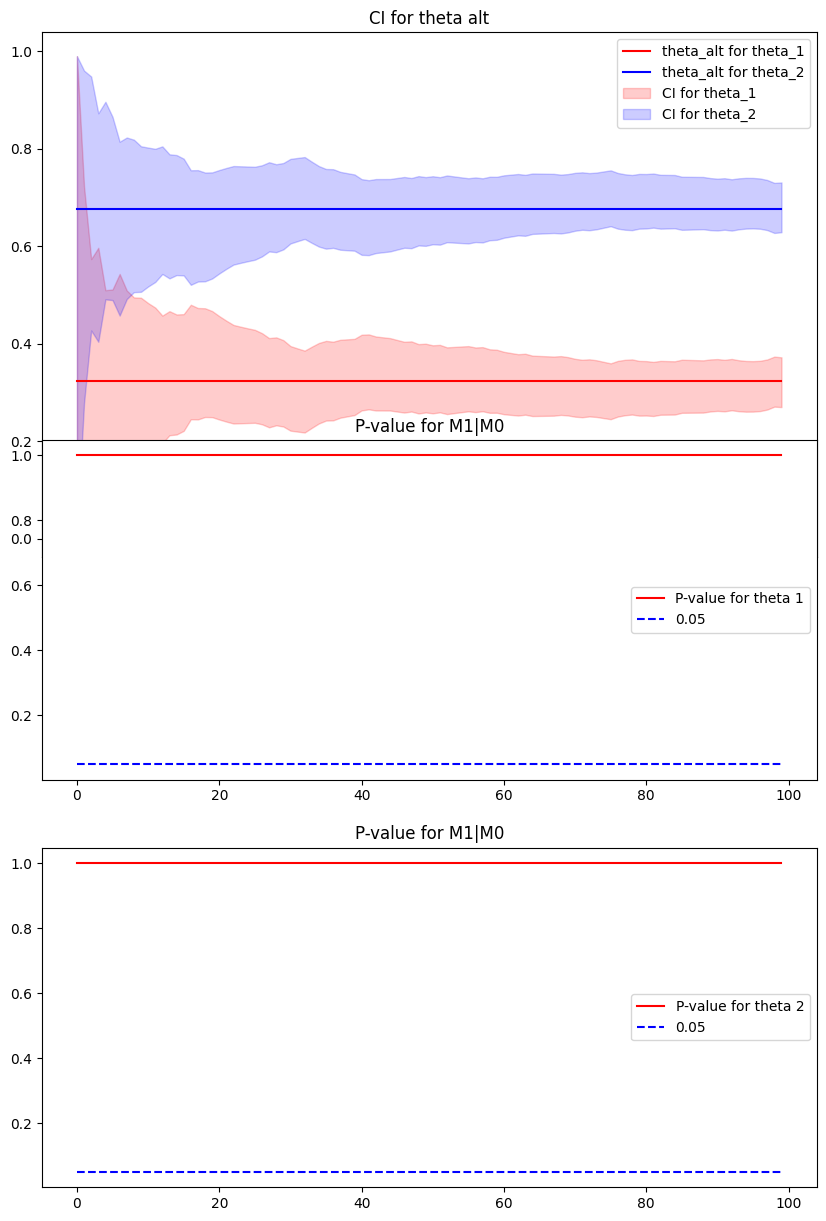

In [65]:
plt.figure(figsize=(10, 15))
plt.subplot(2,1,1)
plt.title("CI for theta alt")
lenght=len(theta_alt_0min_arr)
plt.plot(range(lenght),[theta_alt[0]]*lenght,color='r',label="theta_alt for theta_1")
plt.plot(range(lenght),[theta_alt[1]]*lenght,color='b',label="theta_alt for theta_2")

plt.fill_between(range(lenght),
                 np.array(theta_alt_0min_arr),
                 np.array(theta_alt_0max_arr), color='r',
                 alpha=0.2, label="CI for theta_1")  # alpha controls transparency


plt.fill_between(range(lenght),
                 np.array(theta_alt_1min_arr),
                 np.array(theta_alt_1max_arr), color='b',
                 alpha=0.2, label="CI for theta_2")  # alpha controls transparency


# plt.plot(range(len(theta_alt_arr)),np.array(theta_alt_min_arr)[:,0],label="theta_alt min for theta_1")
# plt.plot(range(len(theta_alt_arr)),np.array(theta_alt_max_arr)[:,0],label="theta_alt max for theta_1")
# plt.plot(range(len(theta_alt_arr)),np.array(theta_alt_min_arr)[:,1],label="theta_alt min for theta_2")
# plt.plot(range(len(theta_alt_arr)),np.array(theta_alt_max_arr)[:,1],label="theta_alt max for theta_2")

plt.legend()
plt.subplot(3,1,2)
plt.title("P-value for M1|M0")
plt.plot(range(lenght),np.array(seq_p_val_arr)[:,0],color='r',label="P-value for theta 1")
plt.plot(range(lenght),[0.05]*lenght,'--',color='b',label="0.05")
plt.legend()
plt.plot()


plt.subplot(3,1,3)
plt.title("P-value for M1|M0")
plt.plot(range(lenght),np.array(seq_p_val_arr)[:,1],color='r',label="P-value for theta 2")
plt.plot(range(lenght),[0.05]*lenght,'--',color='b',label="0.05")
plt.legend()
plt.plot()

In [ ]:
np.round(theta_alt_0min_arr,3)

In [ ]:
np.round(theta_alt_1min_arr,3)

In [ ]:
np.round(theta_alt_1max_arr,3)

In [ ]:
np.round(theta_alt_0max_arr,3)

In [ ]:
1/np.array(on_theta_hist_arr) < (1/0.05)

In [ ]:
from scipy.stats import gaussian_kde

event_timestamps=np.array([1,2])
kde=gaussian_kde(vectors_alt[:100,1])
time_points=np.linspace(0,100,100)
plt.plot(time_points,kde(time_points))

In [ ]:
time_points

In [ ]:
num_time_points=100
probabilities=np.random.dirichlet(alpha=[1,2,3,4],size=1).flatten()
num_samples=1000
event_times=np.random.choice(np.arange(1,5),size=num_samples,p=probabilities/np.sum(probabilities))
kde=gaussian_kde(event_times,bw_method='scott')
time_grid=np.linspace(1,num_time_points,1000)
mu_t=kde(time_grid)
plt.plot(time_grid,mu_t)
